### Predicting Stock Movement with Random Forest

### Steps Involve are as follows:

* Load the Data
* Data Preliminary Analysis
* Data Preprocessing: 
    * Ticker Symbol
    * Smoothening the data
* Data Experimentation and Model Building Stages
    * Indicator Calculation:
        * Stochastic Oscillator
        * Williams %R
        * Relative Strength Index (RSI)
        * Moving Average Convergence Divergence (MACD)
        * Price Rate of Change
        * On Balance Volume
* Data Summarization
    * Symbol Description
* Data Visualization
* Building the Model: 
    * Creating the Prediction Column
    * Removing NaN Values
    * Splitting the Data
* Model Evaluation: 
    * Accuracy
    * Feature Importance
    * Feature Importance Graphing
    * Out-Of-Bag Error Score
* Model Improvement: 
    * Randomized Search
    * Running Randomized Search

In [1]:
#importing libraries
import os
import sys
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

### Load the Data

In [2]:
#Loading the data
price_df = pd.read_csv(r"C:\Users\ezeki\Downloads\Data Science Career Focus\Sigma Coding\price_data.csv")

In [3]:
price_df.head()

,close,datetime,high,low,open,symbol,volume
0,105.51,1513144800000,107.11,105.48,106.70,JPM,15020293
1,104.66,1513231200000,106.45,104.64,106.12,JPM,13034232
2,106.14,1513317600000,106.52,105.20,105.79,JPM,29350598
3,106.96,1513576800000,107.63,106.48,107.19,JPM,12713148
4,106.51,1513663200000,107.49,106.44,107.35,JPM,12149937


### Data Preliminary Analysis and Discovery

In [151]:
#Getting information about the price_df
price_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2455 entries, 2029 to 503
Data columns (total 20 columns):
symbol                  2455 non-null object
datetime                2455 non-null int64
close                   2455 non-null float64
high                    2455 non-null float64
low                     2455 non-null float64
open                    2455 non-null float64
volume                  2455 non-null int64
change_in_price         2455 non-null float64
down_days               2455 non-null float64
up_days                 2455 non-null float64
RSI                     2455 non-null float64
low_14                  2455 non-null float64
high_14                 2455 non-null float64
k_percent               2455 non-null float64
r_percent               2455 non-null float64
MACD                    2455 non-null float64
MACD_EMA                2455 non-null float64
Price_Rate_Of_Change    2455 non-null float64
On Balance Volume       2455 non-null int64
Prediction              

In [4]:
#Needing just the close
price_df = price_df[['symbol', 'datetime', 'close', 'high', 'low','open','volume']]

''' 

First, for average investors, the return of an asset is a complete and scale-free summary of the investment opportunity.
Second, return series are easier to handle than prices series as they have more attractive statistical properties

'''

# sort the values by symbol and then date 
price_df.sort_values(by = ['symbol','datetime'], inplace = True)

# calculate the change in price
price_df['change_in_price'] = price_df['close'].diff()

### Data Processing: Ticker Symbol

In [5]:
# identify rows where the symbol changes
mask = price_df['symbol'] != price_df['symbol'].shift(1)

In [6]:
# For those rows, let's make the value null
price_df['change_in_price'] = np.where(mask == True, np.nan, price_df['change_in_price'])

In [7]:
# print the rows that have a null value, should only be 5 
price_df[price_df.isna().any(axis = 1)]

,symbol,datetime,close,high,low,open,volume,change_in_price
2016,ARWR,1513144800000,3.40,3.41,3.01,3.30,2037395,NaN
504,COST,1513144800000,188.28,190.12,187.80,188.53,3062856,NaN
1512,HD,1513144800000,183.03,183.67,182.00,182.01,5177363,NaN
1008,IBM,1513144800000,153.91,156.73,153.89,156.60,5661618,NaN
0,JPM,1513144800000,105.51,107.11,105.48,106.70,15020293,NaN


### Data Preprocessing: Smoothing the Data (OPTIONAL)

The goal of smoothing is to remove the randomness and noise from our price data. in other words, we don't get a spiky up and down graph but instead a smoother one. Additionally, this will help the model to more easily identify long-term trends.

Here is how to calculate the smoothed version of the prices using pandas:

In [8]:
# define the number of days out you want to predict
days_out = 30

In [9]:
# grouping the symbol, then appy the rolling function and grab the Min and Max.
price_df_smoothed = price_df.groupby(['symbol'])[['close','low','high','open','volume']].transform(lambda x: x.ewm(span = days_out).mean())

In [10]:
# Join the smoothed columns with the symbol and datetime column from the old data frame.
smoothed_df = pd.concat([price_df[['symbol', 'datetime']], price_df_smoothed], axis=1, sort=False)

smoothed_df.head()

,symbol,datetime,close,low,high,open,volume
2016,ARWR,1513144800000,3.400000,3.010000,3.410000,3.300000,2.037395e+06
2017,ARWR,1513231200000,3.270833,3.030667,3.415167,3.356833,1.864160e+06
2018,ARWR,1513317600000,3.224284,3.048219,3.338612,3.297475,1.665444e+06
2019,ARWR,1513576800000,3.225859,3.073508,3.354149,3.256840,1.552160e+06
2020,ARWR,1513663200000,3.233627,3.108454,3.360030,3.255284,1.455788e+06


### Data Summarization

### Symbol Description
* HD - Home Depot
* JPM - JPMorgan Chase & Co.
* IMB - International Business Machines Corporation
* ARWR - Arrowhead Pharmaceuticals, Inc.
* COST - Costco Wholesale Corporation

In [150]:
print(price_df['symbol'].value_counts())

ARWR    491
HD      491
IBM     491
COST    491
JPM     491
Name: symbol, dtype: int64


All symbols are evenly distributed 

### Data Visualization

Text(0.5, 1.0, 'Symbol ARWR trend to close of the day')

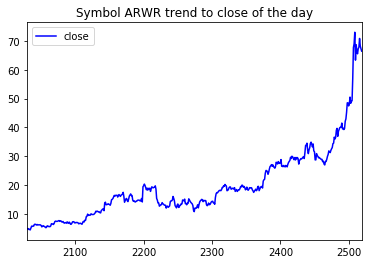

In [169]:
price_df[price_df.symbol == 'ARWR'][['close']].plot(style='blue')
plt.title('Symbol ARWR trend to close of the day')

We can see that ARWR has a rising trend according to it's close of the day

Text(0.5, 1.0, 'Symbol HD trend to close of the day')

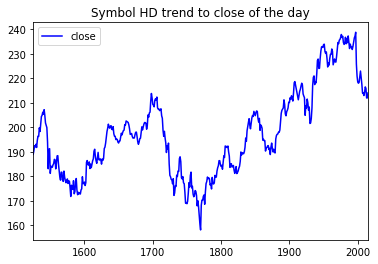

In [161]:
price_df[price_df.symbol == 'HD'][['close']].plot(style='blue')
plt.title('Symbol HD trend to close of the day')

Home of Depot has a rising trend also overtime

Text(0.5, 1.0, 'Symbol IBM trend to close of the day')

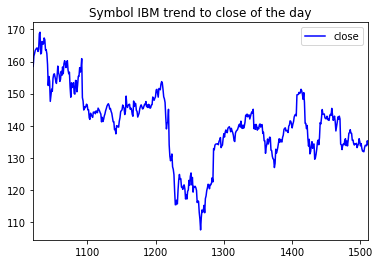

In [166]:
price_df[price_df.symbol == 'IBM'][['close']].plot(style='blue')
plt.title('Symbol IBM trend to close of the day')

International Business Machines Corporation has decline and subsequently consolidating 

Text(0.5, 1.0, 'Symbol COST trend to close of the day')

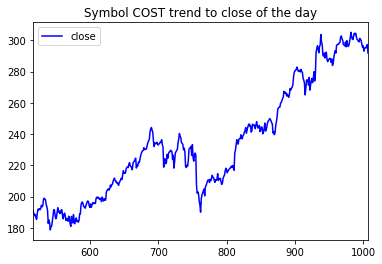

In [167]:
price_df[price_df.symbol == 'COST'][['close']].plot(style='blue')
plt.title('Symbol COST trend to close of the day')

Costco Wholesale Corporation has a rising trend overtime

Text(0.5, 1.0, 'Symbol JPM trend to close of the day')

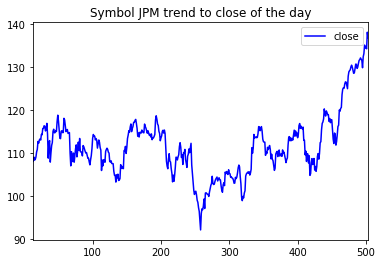

In [168]:
price_df[price_df.symbol == 'JPM'][['close']].plot(style='blue')
plt.title('Symbol JPM trend to close of the day')

JPMorgan Chase & Co. declined a bit and subsequently rose up and continued in an uptrend

### Model Building Stages

### Indicator Calculation: Relative Strength Index (RSI)

Definition: RSI is a popular momentum indicator that determines whether the stock is overbought or oversold

In [15]:
# Calculate the 14 day RSI
n = 14

# First make a copy of the data from twice
up_df, down_df = price_df[['symbol','change_in_price']].copy(), price_df[['symbol','change_in_price']].copy()

In [16]:
# For up days, if the change is less than 0 set to 0.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

In [17]:
# For down days, if the change is greater than 0 set to 0.
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

In [18]:
# We need change in price to be absolute
down_df['change_in_price'] = down_df['change_in_price'].abs()

In [19]:
# Calculate the EWMA (Exponential Weighted Moving Average), meaning older values are given less weight compared to newer values.
ewma_up = up_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

ewma_down = down_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

In [20]:
# Calculate the Relative Strength
relative_strength = ewma_up / ewma_down

In [24]:
# Calculate the Relative Strenth Index
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

In [25]:
# Add the info to the data frame
price_df['down_days'] = down_df['change_in_price']
price_df['up_days'] = up_df['change_in_price']
price_df['RSI'] = relative_strength_index

In [26]:
# Display the head
price_df.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI
2016,ARWR,1513144800000,3.40,3.4100,3.0100,3.30,2037395,NaN,NaN,NaN,NaN
2017,ARWR,1513231200000,3.15,3.4200,3.0500,3.41,1702102,-0.25,0.25,0.00,0.000000
2018,ARWR,1513317600000,3.14,3.2000,3.0800,3.19,1305646,-0.01,0.01,0.00,0.000000
2019,ARWR,1513576800000,3.23,3.3950,3.1400,3.15,1254305,0.09,0.00,0.09,31.419705
2020,ARWR,1513663200000,3.26,3.3800,3.2271,3.25,1128590,0.03,0.00,0.03,38.813758
2021,ARWR,1513749600000,3.43,3.5850,3.2700,3.29,1378629,0.17,0.00,0.17,64.112604
2022,ARWR,1513836000000,3.38,3.5398,3.3700,3.40,1105958,-0.05,0.05,0.00,56.223402
2023,ARWR,1513922400000,3.71,3.8267,3.4240,3.45,1996695,0.33,0.00,0.33,77.400849
2024,ARWR,1514268000000,3.79,3.8600,3.6200,3.70,1054488,0.08,0.00,0.08,80.094431
2025,ARWR,1514354400000,3.84,3.9100,3.7610,3.82,1252920,0.05,0.00,0.05,81.669970


### Indicator Calculation: Stochastic Oscillator

Definition: Stochastic Oscillator follows the speed or the momentum of the price. As a rule, momentum changes before the price changes. It measures the level of the closing price relative to the low-high range over a period of time.

We specify our window, which in this case is 14 periods, and then specify measurement we want to apply to each window.

In [38]:
# Calculate the stochastic Oscillator
n = 14

# Make a copy of the high and low column,
low_14, high_14 = price_df[['symbol','low']].copy(), price_df[['symbol','high']].copy()

In [39]:
# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('symbol')['low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('symbol')['high'].transform(lambda x: x.rolling(window=n).max())

In [40]:
# Calculate the Stochastic Oscillator.
k_percent = 100 * ((price_df['close'] - low_14) / (high_14 - low_14))

In [41]:
# Add the info to the data frame
price_df['low_14'] = low_14
price_df['high_14'] = high_14
price_df['k_percent'] = k_percent

In [42]:
#Diplay the head
price_df.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent
2016,ARWR,1513144800000,3.40,3.4100,3.0100,3.30,2037395,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017,ARWR,1513231200000,3.15,3.4200,3.0500,3.41,1702102,-0.25,0.25,0.00,0.000000,NaN,NaN,NaN
2018,ARWR,1513317600000,3.14,3.2000,3.0800,3.19,1305646,-0.01,0.01,0.00,0.000000,NaN,NaN,NaN
2019,ARWR,1513576800000,3.23,3.3950,3.1400,3.15,1254305,0.09,0.00,0.09,31.419705,NaN,NaN,NaN
2020,ARWR,1513663200000,3.26,3.3800,3.2271,3.25,1128590,0.03,0.00,0.03,38.813758,NaN,NaN,NaN
2021,ARWR,1513749600000,3.43,3.5850,3.2700,3.29,1378629,0.17,0.00,0.17,64.112604,NaN,NaN,NaN
2022,ARWR,1513836000000,3.38,3.5398,3.3700,3.40,1105958,-0.05,0.05,0.00,56.223402,NaN,NaN,NaN
2023,ARWR,1513922400000,3.71,3.8267,3.4240,3.45,1996695,0.33,0.00,0.33,77.400849,NaN,NaN,NaN
2024,ARWR,1514268000000,3.79,3.8600,3.6200,3.70,1054488,0.08,0.00,0.08,80.094431,NaN,NaN,NaN
2025,ARWR,1514354400000,3.84,3.9100,3.7610,3.82,1252920,0.05,0.00,0.05,81.669970,NaN,NaN,NaN


### Indicator Calculation: Williams %R

Definition: Williams %R ranges from -100 to 0. When its value is above -20, it indicates a sell signal and when its value it below -80, it indicates a buy signal.

#### Code 
Identical to the stochastic Oscillator, we change the arrangement of the formula

In [43]:
# Calculate the Williams %R
n = 14

# Make a copy of the high and low column.
low_14, high_14 = price_df[['symbol','low']].copy(), price_df[['symbol','high']].copy()

In [44]:
# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('symbol')['low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('symbol')['high'].transform(lambda x: x.rolling(window = n).max())

In [45]:
# Calculate William %R indicator
r_percent = ((high_14 - price_df['close']) / (high_14 - low_14)) * - 100
# Ad the info to the data frame.
price_df['r_percent'] = r_percent

In [46]:
# Display the head.
price_df.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
2016,ARWR,1513144800000,3.40,3.4100,3.0100,3.30,2037395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017,ARWR,1513231200000,3.15,3.4200,3.0500,3.41,1702102,-0.25,0.25,0.00,0.000000,NaN,NaN,NaN,NaN
2018,ARWR,1513317600000,3.14,3.2000,3.0800,3.19,1305646,-0.01,0.01,0.00,0.000000,NaN,NaN,NaN,NaN
2019,ARWR,1513576800000,3.23,3.3950,3.1400,3.15,1254305,0.09,0.00,0.09,31.419705,NaN,NaN,NaN,NaN
2020,ARWR,1513663200000,3.26,3.3800,3.2271,3.25,1128590,0.03,0.00,0.03,38.813758,NaN,NaN,NaN,NaN
2021,ARWR,1513749600000,3.43,3.5850,3.2700,3.29,1378629,0.17,0.00,0.17,64.112604,NaN,NaN,NaN,NaN
2022,ARWR,1513836000000,3.38,3.5398,3.3700,3.40,1105958,-0.05,0.05,0.00,56.223402,NaN,NaN,NaN,NaN
2023,ARWR,1513922400000,3.71,3.8267,3.4240,3.45,1996695,0.33,0.00,0.33,77.400849,NaN,NaN,NaN,NaN
2024,ARWR,1514268000000,3.79,3.8600,3.6200,3.70,1054488,0.08,0.00,0.08,80.094431,NaN,NaN,NaN,NaN
2025,ARWR,1514354400000,3.84,3.9100,3.7610,3.82,1252920,0.05,0.00,0.05,81.669970,NaN,NaN,NaN,NaN


### Indicator Calculation: Moving Average Convergence Divergence (MACD)

Definition: EMA stands for Exponential Moving Average. When the MACD goes below the SignalLine, it indicates a sell signal. When it goes above the signalLine, it indicates a buy signal.

In [49]:
# Calculate the MACD
ema_26 = price_df.groupby('symbol')['close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_df.groupby('symbol')['close'].transform(lambda x: x.ewm(span= 12).mean())
macd = ema_12 - ema_26

In [52]:
# Calculate the EMA
ema_9_macd = macd.ewm(span = 9).mean()

In [53]:
# Store the data in the data frame
price_df['MACD'] = macd
price_df['MACD_EMA'] = ema_9_macd

In [54]:
# Print the head
price_df.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA
2016,ARWR,1513144800000,3.40,3.4100,3.0100,3.30,2037395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2017,ARWR,1513231200000,3.15,3.4200,3.0500,3.41,1702102,-0.25,0.25,0.00,0.000000,NaN,NaN,NaN,NaN,-0.005609,-0.003116
2018,ARWR,1513317600000,3.14,3.2000,3.0800,3.19,1305646,-0.01,0.01,0.00,0.000000,NaN,NaN,NaN,NaN,-0.007457,-0.004895
2019,ARWR,1513576800000,3.23,3.3950,3.1400,3.15,1254305,0.09,0.00,0.09,31.419705,NaN,NaN,NaN,NaN,-0.004865,-0.004885
2020,ARWR,1513663200000,3.26,3.3800,3.2271,3.25,1128590,0.03,0.00,0.03,38.813758,NaN,NaN,NaN,NaN,-0.002161,-0.004075
2021,ARWR,1513749600000,3.43,3.5850,3.2700,3.29,1378629,0.17,0.00,0.17,64.112604,NaN,NaN,NaN,NaN,0.006775,-0.001134
2022,ARWR,1513836000000,3.38,3.5398,3.3700,3.40,1105958,-0.05,0.05,0.00,56.223402,NaN,NaN,NaN,NaN,0.010123,0.001715
2023,ARWR,1513922400000,3.71,3.8267,3.4240,3.45,1996695,0.33,0.00,0.33,77.400849,NaN,NaN,NaN,NaN,0.027901,0.008008
2024,ARWR,1514268000000,3.79,3.8600,3.6200,3.70,1054488,0.08,0.00,0.08,80.094431,NaN,NaN,NaN,NaN,0.043756,0.016266
2025,ARWR,1514354400000,3.84,3.9100,3.7610,3.82,1252920,0.05,0.00,0.05,81.669970,NaN,NaN,NaN,NaN,0.056942,0.025380


### Indicator Calculation: Price Rate of Change

Definition: It measures the most recent change in price with respect to the price in n days ago.

In this case, the paper never provided a specific n, but after doing some research, I landed on an n of 9 because this seemed to be the standard window. Now, it's important to note that the paper changes n depending on the window, so technically I'm not doing exactly like they did. For example, if my prediction window was 30 days then n should be 30.

In [55]:
# Calculate the Price Rate of Change
n = 9
# Calculate the Rate of Change in the Price, and store it in the Data Frame.
price_df['Price_Rate_Of_Change'] = price_df.groupby('symbol')['close'].transform(lambda x: x.pct_change(periods = n))

In [56]:
# Print the first 30 rows
price_df.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
2016,ARWR,1513144800000,3.40,3.4100,3.0100,3.30,2037395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
2017,ARWR,1513231200000,3.15,3.4200,3.0500,3.41,1702102,-0.25,0.25,0.00,0.000000,NaN,NaN,NaN,NaN,-0.005609,-0.003116,NaN
2018,ARWR,1513317600000,3.14,3.2000,3.0800,3.19,1305646,-0.01,0.01,0.00,0.000000,NaN,NaN,NaN,NaN,-0.007457,-0.004895,NaN
2019,ARWR,1513576800000,3.23,3.3950,3.1400,3.15,1254305,0.09,0.00,0.09,31.419705,NaN,NaN,NaN,NaN,-0.004865,-0.004885,NaN
2020,ARWR,1513663200000,3.26,3.3800,3.2271,3.25,1128590,0.03,0.00,0.03,38.813758,NaN,NaN,NaN,NaN,-0.002161,-0.004075,NaN
2021,ARWR,1513749600000,3.43,3.5850,3.2700,3.29,1378629,0.17,0.00,0.17,64.112604,NaN,NaN,NaN,NaN,0.006775,-0.001134,NaN
2022,ARWR,1513836000000,3.38,3.5398,3.3700,3.40,1105958,-0.05,0.05,0.00,56.223402,NaN,NaN,NaN,NaN,0.010123,0.001715,NaN
2023,ARWR,1513922400000,3.71,3.8267,3.4240,3.45,1996695,0.33,0.00,0.33,77.400849,NaN,NaN,NaN,NaN,0.027901,0.008008,NaN
2024,ARWR,1514268000000,3.79,3.8600,3.6200,3.70,1054488,0.08,0.00,0.08,80.094431,NaN,NaN,NaN,NaN,0.043756,0.016266,NaN
2025,ARWR,1514354400000,3.84,3.9100,3.7610,3.82,1252920,0.05,0.00,0.05,81.669970,NaN,NaN,NaN,NaN,0.056942,0.025380,0.129412


### Indicator Calculation: On Balance Volume
Definition: On balance volume (OBV) (Granville 1979) utilizes changes in volume to estimate changes in stock prices.

This technical indicator is used to nd buying and selling trends of a stock, by considering the cumulative volume. It cumulatively adds the volumes on days when the prices group, and subtracts the volume on the days when prices go down, compared to the prices of the previous day

### Code:

The function simply calculates the diff for the closing price and uses a for loop to loop through each row in the volume column. If the change in price was greater than 0 we add the volume, if it's less than 0 we substract the volume and if it's 0 then we leave it alone.

In [58]:
def obv(group):
    
    #Grab the volume and close column.
    volume = group['volume']
    change = group['close'].diff()
    
    # initialize the previous OBV
    prev_obv = 0
    obv_values = []
    
    # Calculate the On Balance Volume
    for i, j in zip(change, volume):
        
        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv
        
        # OBV.append(current_OBV)
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Return a pandas series 
    return pd.Series(obv_values, index = group.index)

# apply the function to each group
obv_groups = price_df.groupby('symbol').apply(obv)

# add to the data frame, but drop the old index, before adding it.
price_df['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)

#display the data frame
price_df.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
2016,ARWR,1513144800000,3.40,3.4100,3.0100,3.30,2037395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0
2017,ARWR,1513231200000,3.15,3.4200,3.0500,3.41,1702102,-0.25,0.25,0.00,0.000000,NaN,NaN,NaN,NaN,-0.005609,-0.003116,NaN,-1702102
2018,ARWR,1513317600000,3.14,3.2000,3.0800,3.19,1305646,-0.01,0.01,0.00,0.000000,NaN,NaN,NaN,NaN,-0.007457,-0.004895,NaN,-3007748
2019,ARWR,1513576800000,3.23,3.3950,3.1400,3.15,1254305,0.09,0.00,0.09,31.419705,NaN,NaN,NaN,NaN,-0.004865,-0.004885,NaN,-1753443
2020,ARWR,1513663200000,3.26,3.3800,3.2271,3.25,1128590,0.03,0.00,0.03,38.813758,NaN,NaN,NaN,NaN,-0.002161,-0.004075,NaN,-624853
2021,ARWR,1513749600000,3.43,3.5850,3.2700,3.29,1378629,0.17,0.00,0.17,64.112604,NaN,NaN,NaN,NaN,0.006775,-0.001134,NaN,753776
2022,ARWR,1513836000000,3.38,3.5398,3.3700,3.40,1105958,-0.05,0.05,0.00,56.223402,NaN,NaN,NaN,NaN,0.010123,0.001715,NaN,-352182
2023,ARWR,1513922400000,3.71,3.8267,3.4240,3.45,1996695,0.33,0.00,0.33,77.400849,NaN,NaN,NaN,NaN,0.027901,0.008008,NaN,1644513
2024,ARWR,1514268000000,3.79,3.8600,3.6200,3.70,1054488,0.08,0.00,0.08,80.094431,NaN,NaN,NaN,NaN,0.043756,0.016266,NaN,2699001
2025,ARWR,1514354400000,3.84,3.9100,3.7610,3.82,1252920,0.05,0.00,0.05,81.669970,NaN,NaN,NaN,NaN,0.056942,0.025380,0.129412,3951921


### Building the Model: Creating the Prediction Column

In our case, we have a classification problem because we have two discrete groups, up_days and down_days, and our goal is to take new values (new prices) and classify them into these two groups based on their values.

To create our prediction column, we will group our data frame by each symbol. After we've created our groups, we need to select the close column as this contains the price we need to determine if the stock closed up or down for any given day. Now, we can use a similar logic we used to calculate the price change. However, in this case, we only need to know if the price is higher or lower compared to the previous day.

Take your groups, use the transform method to apply a lambda function to your groups. The lambda function will use the diff() function to compare the current price to the previouse price. We then wrap the results of that function in the numpy.sign() function. That function will return 1.0 for negative values (down days), 1.0 for postive values, and 0.0 for no change (flat days).

In [60]:
# Creating a column we wish to predict

'''
     In this case, Let's create an output that will be 1 if the closing price at time 't' is greater than 't-1'and o otherwise.
     In other words, if the today's closing price is greater than yesterday's closing price it would be 1.
'''
# Group by the 'Symbol' column, then grab the 'Close' column.
close_groups = price_df.groupby('symbol')['close']

In [61]:
# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
close_groups = close_groups.transform(lambda x : np.sign(x.diff()))

C:\Users\ezeki\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sign
  


In [62]:
# Add the data to the main dataframe.
price_df['Prediction'] = close_groups

In [63]:
# Print the head.
price_df.head(15)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction
2016,ARWR,1513144800000,3.40,3.4100,3.0100,3.30,2037395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0,NaN
2017,ARWR,1513231200000,3.15,3.4200,3.0500,3.41,1702102,-0.25,0.25,0.00,0.000000,NaN,NaN,NaN,NaN,-0.005609,-0.003116,NaN,-1702102,-1.0
2018,ARWR,1513317600000,3.14,3.2000,3.0800,3.19,1305646,-0.01,0.01,0.00,0.000000,NaN,NaN,NaN,NaN,-0.007457,-0.004895,NaN,-3007748,-1.0
2019,ARWR,1513576800000,3.23,3.3950,3.1400,3.15,1254305,0.09,0.00,0.09,31.419705,NaN,NaN,NaN,NaN,-0.004865,-0.004885,NaN,-1753443,1.0
2020,ARWR,1513663200000,3.26,3.3800,3.2271,3.25,1128590,0.03,0.00,0.03,38.813758,NaN,NaN,NaN,NaN,-0.002161,-0.004075,NaN,-624853,1.0
2021,ARWR,1513749600000,3.43,3.5850,3.2700,3.29,1378629,0.17,0.00,0.17,64.112604,NaN,NaN,NaN,NaN,0.006775,-0.001134,NaN,753776,1.0
2022,ARWR,1513836000000,3.38,3.5398,3.3700,3.40,1105958,-0.05,0.05,0.00,56.223402,NaN,NaN,NaN,NaN,0.010123,0.001715,NaN,-352182,-1.0
2023,ARWR,1513922400000,3.71,3.8267,3.4240,3.45,1996695,0.33,0.00,0.33,77.400849,NaN,NaN,NaN,NaN,0.027901,0.008008,NaN,1644513,1.0
2024,ARWR,1514268000000,3.79,3.8600,3.6200,3.70,1054488,0.08,0.00,0.08,80.094431,NaN,NaN,NaN,NaN,0.043756,0.016266,NaN,2699001,1.0
2025,ARWR,1514354400000,3.84,3.9100,3.7610,3.82,1252920,0.05,0.00,0.05,81.669970,NaN,NaN,NaN,NaN,0.056942,0.025380,0.129412,3951921,1.0


### Building the Model: Removing NaN Values

The random forest can't accept Nan values, so we will need to remove them before feeding the data in. The code below prints the number of rows before dropping the NaN values, use the dropna method to remove any rows NaN values and then displays the number of rows after dropping the NaN values.

In [65]:
# We need to remove all rows that have an NaN value.
print('Before NaN Drop we have {} rows and {} columns'.format(price_df.shape[0], price_df.shape[1]))

# Any row that has a 'NaN' value will be dropped.
price_df = price_df.dropna()

# Display how much we have left now.
print('After NaN Drop we have {} rows and {} columns'.format (price_df.shape[0], price_df.shape[1]))

# Print the head.
price_df.head()

Before NaN Drop we have 2520 rows and 20 columns
After NaN Drop we have 2455 rows and 20 columns


,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction
2029,ARWR,1514959200000,4.64,4.88,3.770,3.79,5875479,0.92,0.00,0.92,82.451324,3.0100,4.88,87.165775,-12.834225,0.114979,0.061321,0.423313,10352916,1.0
2030,ARWR,1515045600000,4.85,5.13,4.500,4.58,3402024,0.21,0.00,0.21,84.742603,3.0500,5.13,86.538462,-13.461538,0.164049,0.082616,0.413994,13754940,1.0
2031,ARWR,1515132000000,4.87,5.23,4.660,4.86,2278246,0.02,0.00,0.02,84.958420,3.0800,5.23,83.255814,-16.744186,0.200433,0.106862,0.440828,16033186,1.0
2032,ARWR,1515391200000,4.55,4.90,4.370,4.88,2659533,-0.32,0.32,0.00,67.366376,3.1400,5.23,67.464115,-32.535885,0.205891,0.127124,0.226415,13373653,-1.0
2033,ARWR,1515477600000,4.62,4.90,4.455,4.58,1430439,0.07,0.00,0.07,68.987239,3.2271,5.23,69.544161,-30.455839,0.211957,0.144402,0.218997,14804092,1.0


### Building the Model: Splitting the Data

If you remember back to our series on regression analysis, we have split our data into a training set and testing set. For Random Forest, we need to do the same, so we need to identify our input columns which are the following:

1. RSI
2. Stochastic Oscillator
3. William %R
4. Price Rate of Change
5. MACD

Those columns will serve as our X, and our Y column will be the Prediction column, the column that specifies whether the stock closed up or down compared to the previous day.

In [69]:
#Grab our X & Y Columns.
X_Cols = price_df[['RSI', 'k_percent','r_percent','Price_Rate_Of_Change', 'MACD', 'On Balance Volume']]
Y_Cols = price_df['Prediction']

X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)
                                        
# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)                                       

# Make predictions
y_pred = rand_frst_clf.predict(X_test)
                                        

### Model Evaluation: Accuracy

We've built our model, so let's see how accurate it is. SciKit learn, again, makes the process of evaluating our model very easy by providing a bunch of built-in metrics that we can call.

One of those metrics is the accuracy_score.

In [72]:
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  71.17263843648209


In [170]:
#Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

C:\Users\ezeki\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        -1.0       0.71      0.68      0.69       290
         0.0       0.00      0.00      0.00         4
         1.0       0.71      0.75      0.73       320

    accuracy                           0.71       614
   macro avg       0.47      0.48      0.48       614
weighted avg       0.71      0.71      0.71       614



In [202]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
new = confusion_matrix(y_test, y_pred)
cf = (np.delete(new, [1,1], axis=1))
cm = (np.delete(cf, [1], axis=0))
print(cm)

[[196  94]
 [ 79 241]]


In [203]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rf_matrix = cm

display(rf_matrix)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

array([[196,  94],
       [ 79, 241]], dtype=int64)

Accuracy: 0.7163934426229508
Percision: 0.7194029850746269
Recall: 0.753125
Specificity: 0.6758620689655173


### Moving Evaluation: Feature Importance

Feature importance can be calculated two ways in Random Forest:

Gini-Based Importance
Accuracy-Based Importance
Here is how both measures of importance are calculated.

With sklearn they use the Gini-Importance metric for the Random Forest Algorithm.

We can see in our model, that the most important feature is k_percent and our least important feature is Price_Rate_Of_Change.

In [78]:
# Calculate feature importance and store in pandas series
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
feature_imp

k_percent               0.208556
r_percent               0.189358
RSI                     0.172526
MACD                    0.160918
Price_Rate_Of_Change    0.153785
On Balance Volume       0.114858
dtype: float64

### Model Evaluation: Feature Importance Graphing

Text(0.5, 1.0, 'Random Forest: Feature Importance Graph')

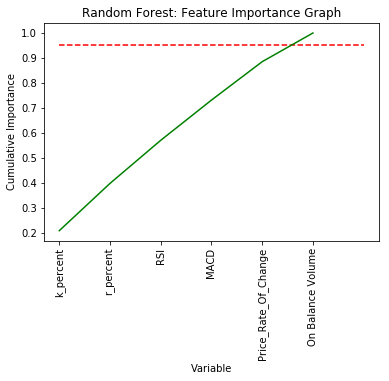

In [82]:
x_values = list(range(len(rand_frst_clf.feature_importances_)))

# Cumulative importances
cumulative_importances = np.cumsum(feature_imp.values)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin = 0, xmax = len(feature_imp), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, feature_imp.index, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Random Forest: Feature Importance Graph')

### Model Evaluation: Out-Of-Bag Error Score

In [84]:
print('Random Forest Out-Of-Bag Error Score: {}'.format(rand_frst_clf.oob_score_))

Random Forest Out-Of-Bag Error Score: 0.6969038565996741


### Model Improvement: Randomized Search

With Random Forest, we have to try different values to find what the optimal values should be for each of the parameters. Fortunately, for us, this can be done using the RandomizedSearchCV method provided by sklearn.

In [86]:
# Number of trees in random forest
# Number of trees is not a parameter that should be tuned, but just set large enough usually. There is no risk of overfitting in random forest with growing number of # trees, as they are trained independently from each other. 
n_estimators = list(range(200, 2000, 200))

# Number of features to consider at every split
max_features = ['auto', 'sqrt', None, 'log2']

# Maximum number of levels in tree
# Max depth is a parameter that most of the times should be set as high as possible, but possibly better performance can be achieved by setting it lower.
max_depth = list(range(10, 110, 10))
max_depth.append(None)

# Minimum number of samples required to split a node
# Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree. Too high values can also lead to # under-fitting hence depending on the level of underfitting or overfitting, you can tune the values for min_samples_split.
min_samples_split = [2, 5, 10, 20, 30, 40]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 7, 12, 14, 16 ,20]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid_ = pd.Series(random_grid)

print(random_grid_)

n_estimators         [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1...
max_features                                  [auto, sqrt, None, log2]
max_depth              [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
min_samples_split                               [2, 5, 10, 20, 30, 40]
min_samples_leaf                             [1, 2, 7, 12, 14, 16, 20]
bootstrap                                                [True, False]
dtype: object


### Model Improvement: Running Randomized Search

In [87]:
# New Random Forest Classifier to house optimal parameters 
rt = RandomForestClassifier()

# Specify the details of our Randomized Search
rt_random = RandomizedSearchCV(estimator = rt, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rt_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 14.5min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt', None,
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 7, 12, 14,
                                                             16, 20],
                                        'min_samples_split': [2, 5, 10, 20, 30,
                                                              40],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800]},
          

In [96]:
# With the new Random Classifier trained we can proceed to our regular steps, prediction.
rt_random.predict(X_test)

'''
    ACCURACY
'''
# Once the predictions have been made, then grab the accuracy score.
print('Correct Prediction (%): ', accuracy_score(y_test, rt_random.predict(X_test), normalize = True) * 100.0)

'''
    CLASSIFICATION REPORT
'''
'''
# Define the target names
target_names = ['Down Day', 'Up Day']

# Build a classification report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
display(report_df)
print('\n')
'''
'''
    FEATURE IMPORTANCE
'''

# Calculate feature importance and store in pandas series 
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
display(feature_imp)

Correct Prediction (%):  73.9413680781759


k_percent               0.208556
r_percent               0.189358
RSI                     0.172526
MACD                    0.160918
Price_Rate_Of_Change    0.153785
On Balance Volume       0.114858
dtype: float64

In [117]:
price_df.to_csv('final_metrics.csv')

In [120]:
price_df.head()

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction
2029,ARWR,1514959200000,4.64,4.88,3.770,3.79,5875479,0.92,0.00,0.92,82.451324,3.0100,4.88,87.165775,-12.834225,0.114979,0.061321,0.423313,10352916,1.0
2030,ARWR,1515045600000,4.85,5.13,4.500,4.58,3402024,0.21,0.00,0.21,84.742603,3.0500,5.13,86.538462,-13.461538,0.164049,0.082616,0.413994,13754940,1.0
2031,ARWR,1515132000000,4.87,5.23,4.660,4.86,2278246,0.02,0.00,0.02,84.958420,3.0800,5.23,83.255814,-16.744186,0.200433,0.106862,0.440828,16033186,1.0
2032,ARWR,1515391200000,4.55,4.90,4.370,4.88,2659533,-0.32,0.32,0.00,67.366376,3.1400,5.23,67.464115,-32.535885,0.205891,0.127124,0.226415,13373653,-1.0
2033,ARWR,1515477600000,4.62,4.90,4.455,4.58,1430439,0.07,0.00,0.07,68.987239,3.2271,5.23,69.544161,-30.455839,0.211957,0.144402,0.218997,14804092,1.0
